# Network Modelling within CLIMADA

This tutorial gives insights into some basic network modelling functionalities within `climada_petals.engine`.

The examples will focus on interdependent critical infrastructure and failure cascades induced by natural hazards. 

For in-depth information, see the scientific publication underlying this work:
_Mühlhofer, E., E. E. Koks, C. M. Kropf, G. Sansavini, and D. N. Bresch, 2023: A generalized natural hazard risk modelling framework for infrastructure failure cascades. Reliability Engineering & System Safety, **234**, 109 194, [doi:10.1016/j.ress.2023.109194](doi:10.1016/j.ress.2023.109194)_

## Outline

* [**Part 1:**](#Part1) Making networks & graphs 
* [**Part 2:**](#Part2) Making links among subgraphs
* [**Part 3:**](#Part3) Compute functionality states & propagate impacts among graphs


<a id='Part1'></a>
## Part 1 - Making networks & graphs

### Generic basic example to create a network

The `Network` class is essentially a static data storage, which keeps track of edge and node data that belong together. It has two attributes, `nodes` and `edges`, GeoDataFrames. Methods of this class mainly organise and curate geographic data, such that it is in a format for which it can be later used to perform graph calculations on it.

**Note:** Many of the simplification functions are originally based on the `trails` GitHub project (A Python toolkit for Trade and tRAnsport Impact and fLow analysiS) which is more extensive than the selected methods presented here. Check out details: https://github.com/ElcoK/trails/tree/main

In [8]:
import geopandas as gpd
from climada_petals.engine.networks import nw_preps
from climada_petals.engine.networks.nw_base import Network

In [ ]:
# a few basic steps to prepare a (meaningful) topological network:
gdf_edges = ...
gdf_nodes = ...

network_simp = Network(gdf_edges, gdf_nodes)

network_simp = nw_preps.add_endpoints(network_simp)
network_simp = nw_preps.add_ids(network_simp)
network_simp = nw_preps.add_topology(network_simp)
network_simp.edges = drop_duplicate_geometries(network_simp.edges,  keep='first')
network_simp = nw_preps.reset_ids(network_simp)

network_simp = nw_preps.ordered_network(network_simp)

### Infrastructure-specific basic example

In [4]:
# read gdfs (store on API for use in tutorial)
roads_che = gpd.read_feather('')
powerlines_che = gpd.read_feather('')
pplants_che = gpd.read_feather('')
health_che = gpd.read_feather('')
people_che = gpd.read_feather('')

In [11]:
# store as "tidy" network objects using specific wrappers
# does all of the above, but also cleans roundabouts, merges degree-2 nodes, add distances, etc.
nw_rd = Network(edges=roads_che)
nw_rd = nw_preps.simplified_network(nw_rd)
nw_rd = nw_preps.ordered_network(nw_rd, attrs={'ci_type':'road'})

nw_pl = Network(edges=powerlines_che)
nw_pl = nw_preps.simplified_network(nw_pl)
nw_pl = nw_preps.ordered_network(nw_pl,attrs={'ci_type':'powerline'})

nw_pp = Network(nodes=pplants_che)
nw_pp = nw_preps.simplified_network(nw_pp)
nw_pp = nw_preps.ordered_network(nw_pp, attrs={'ci_type': 'powerplant'})

nw_hc = Network(nodes=health_che)
nw_hc = nw_preps.simplified_network(nw_hc)
nw_hc = nw_preps.ordered_network(nw_hc,attrs={'ci_type':'healthcare'})

nw_ppl = Network(nodes=people_che)
nw_ppl = nw_preps.simplified_network(nw_ppl)
nw_ppl = nw_preps.ordered_network(nw_ppl, attrs={'ci_type': 'people'})

endpoints: 0it [00:00, ?it/s]
/Users/evelynm/climada_petals/climada_petals/engine/networks/nw_preps.py:653: FutureWarning: In a future version of pandas all arguments of Series.drop_duplicates will be keyword-only.
  return dataframe.iloc[mask.drop_duplicates(keep).index]
topology: 0it [00:00, ?it/s]
/Users/evelynm/climada_petals/climada_petals/engine/networks/nw_preps.py:653: FutureWarning: In a future version of pandas all arguments of Series.drop_duplicates will be keyword-only.
  return dataframe.iloc[mask.drop_duplicates(keep).index]
endpoints: 0it [00:00, ?it/s]
/Users/evelynm/mambaforge/envs/climada_upgradenv/lib/python3.9/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/Users/evelynm/climada_petals/climada_petals/engine/networks/nw_preps.py:653: FutureWarning: In a future version of pandas all argum

### From networks to topological graphs

The `Graph` class contains an `igraph.Graph` representation of the network data, and some util functions to convert to / from a `Network`. Many convenience functions are are written in the module `nw_calcs` around the igraph functions, to work with topological graphs, and to perform CLIMADA impact computations on these networks. 

**Note**: Contrary to the `Network` class, this representation of the data is mainly thought for performing computations, not as a static data storage. Most functions acting on it hence also modify the `Graph` inplace!


Check out the API documentation of the python igraph package: https://python.igraph.org/en/stable/api/index.html


In [12]:
import igraph as ig
from climada_petals.engine.networks.nw_base import Graph

In [13]:
# Turn Networks into undirected Graph object
g_rd = Graph(nw_rd)
g_pl = Graph(nw_pl)
g_pp = Graph(nw_pp)
g_hc = Graph(nw_hc)
g_ppl = Graph(nw_ppl)

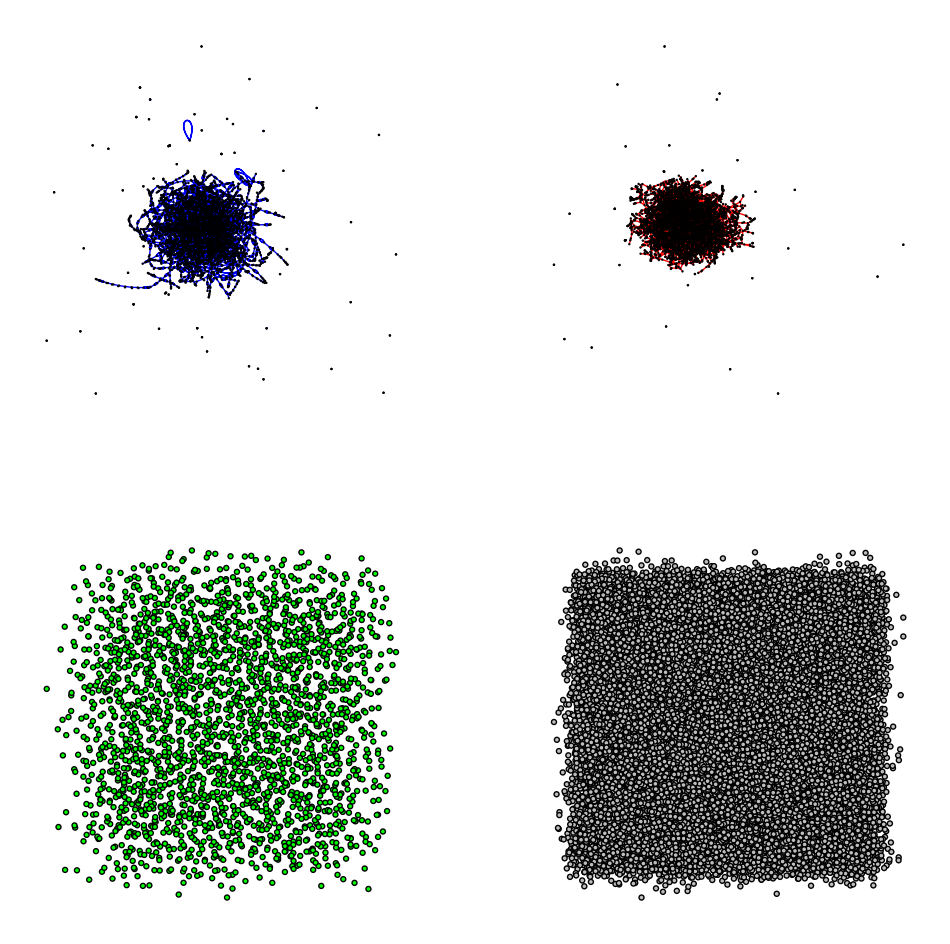

In [19]:
# have a look at some of the graphs (this takes a while...):

import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(12, 12))

ig.plot(g_rd.graph, target=axes.flatten()[0],
       layout = g_rd.graph.layout_fruchterman_reingold(),
       vertex_size=1,
        vertex_color=['blue'],
        edge_width=[1],
        edge_color=['blue'],)

ig.plot(g_pl.graph, target=axes.flatten()[1],
       layout = g_pl.graph.layout_fruchterman_reingold(),
       vertex_size=1,
        vertex_color=['red'],
        edge_width=[1],
        edge_color=['red'],)

ig.plot(g_hc.graph, target=axes.flatten()[2],
       layout = g_hc.graph.layout_fruchterman_reingold(),
       vertex_size=5,
        vertex_color=['green'],
        edge_width=[1],
        edge_color=['green'],)

ig.plot(g_ppl.graph, target=axes.flatten()[3],
       layout = g_ppl.graph.layout_fruchterman_reingold(),
       vertex_size=5,
        vertex_color=['gray'],
        edge_width=[1],
        edge_color=['gray'],)


<a id='Part2'></a>
## Part 2 - Making links among subgraphs

In [26]:
from climada_petals.engine.networks import nw_calcs

ImportError: cannot import name 'DICT_SPEEDS' from 'climada_petals.util.constants' (/Users/evelynm/climada_petals/climada_petals/util/constants.py)

In [22]:
# Linking clusters - example power grid

print(f'Number of clusters in the power grid: {len(g_pl.graph.connected_components())}')
g_pl = nw_calcs.link_clusters(g_pl, link_attrs={'ci_type': 'powerline'})
print(f'Number of clusters in the power grid: {len(g_pl.graph.connected_components())}')
g_pl = nw_calcs.link_clusters(g_pl, link_attrs={'ci_type': 'powerline'})
print(f'Number of clusters in the power grid: {len(g_pl.graph.connected_components())}')

Number of clusters in the power grid: 33


NameError: name 'nw_calcs' is not defined

In [ ]:
# Making one single network & graph
nw_rd_pl_pp_hc_ppl = Network().from_graphs([g_rd, g_pl, g_pp, g_hc, g_ppl])
g_rd_pl_pp_hc_ppl = Graph(nw_rd_pl_pp_hc_ppl)

In [ ]:
# convert into directed graph (doubles all edges!)
g_rd_pl_pp_hc_ppl.graph = g_rd_pl_pp_hc_ppl.graph.as_directed()
g_rd_pl_pp_hc_ppl.directed = True

In [ ]:
# linking sub-graphs #1 (creating "missing infra")

# syntax: each target is connected to max k sources given constraints
g_rd_pl_pp_hc_ppl = nw_calcs.link_vertices_closest_k(g_rd_pl_pp_hc_ppl,
                                                     source_attrs={
                                                         'ci_type': 'powerline'},
                                                     target_attrs={
                                                         'ci_type': 'powerplant'},
                                                     link_attrs={
                                                         'ci_type': 'powerline'},
                                                     dist_thresh=np.inf, bidir=True, k=1)


g_rd_pl_pp_hc_ppl = nw_calcs.link_vertices_closest_k(g_rd_pl_pp_hc_ppl,
                                                     source_attrs={
                                                         'ci_type': 'road'},
                                                     target_attrs={
                                                         'ci_type': 'healthcare'},
                                                     link_attrs={
                                                         'ci_type': 'road'},
                                                     dist_thresh=2000, bidir=True, k=2)



In [ ]:
# linking sub-graphs #2 (creating "dependencies")

# based on nearest-neighbour (& distance)
g_rd_pl_pp_hc_ppl = nw_calcs.link_vertices_closest_k(g_rd_pl_pp_hc_ppl,
                                                     source_attrs={
                                                         'ci_type': 'powerline'},
                                                     target_attrs={
                                                         'ci_type': 'healthcare'},
                                                     link_attrs={
                                                         'ci_type': 'dependency_powerline_healthcare'},
                                                     dist_thresh=10000, bidir=False, k=1)



# based on another link condition
g_rd_pl_pp_hc_ppl = nw_calcs.link_vertices_edgecond(g_rd_pl_pp_hc_ppl,
                                                    target_attrs={
                                                        'ci_type': 'people'},
                                                    edge_attrs={
                                                        'ci_type': 'road'},
                                                    link_attrs={
                                                        'ci_type': 'dependency_road_people'},
                                                    bidir=False)


# based on shortest path distance - the single shortest one
g_rd_pl_pp_hc_ppl = nw_calcs.link_vertices_shortest_paths(g_rd_pl_pp_hc_ppl,
                                                         source_attrs={
                                                             'ci_type': 'healthcare'},
                                                         target_attrs={
                                                             'ci_type': 'people'},
                                                         via_attrs={
                                                             'ci_type': 'road'},
                                                         link_attrs={
                                                             'ci_type': 'dependency_healthcare_people'},
                                                         single_shortest=True,
                                                         dist_thresh=10000, bidir=False)


# based on shortest path distance - all shortest paths below dist_tresh
# delete previously generated edges
g_rd_pl_pp_hc_ppl.graph.delete_edges(g_rd_pl_pp_hc_ppl.graph.es.select(ci_type='dependency_healthcare_people'))
g_rd_pl_pp_hc_ppl = nw_calcs.link_vertices_shortest_paths(g_rd_pl_pp_hc_ppl,
                                                         source_attrs={
                                                             'ci_type': 'healthcare'},
                                                         target_attrs={
                                                             'ci_type': 'people'},
                                                         via_attrs={
                                                             'ci_type': 'road'},
                                                         link_attrs={
                                                             'ci_type': 'dependency_healthcare_people'},
                                                         single_shortest=False,
                                                         dist_thresh=10000, bidir=False)


In [ ]:
# examine that everything went right:
vs_hc = g_rd_pl_pp_hc_ppl.graph.vs.select(ci_type='healthcare')
vs_pp = g_rd_pl_pp_hc_ppl.graph.vs.select(ci_type='powerplant')


Further linking mechanisms not part of this implementation ():
* Links based on a friction surface

<a id='Part3'></a>
## Part 3 - Compute functionality states & propagate impacts among graphs